### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BBSBSBSB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)
STAT_Descriptions

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12493
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    400.8| 47.4306| -94.0586|       TMAX|USC00219059|    20|[00 7E 40 D2 00 D...|1898.0|BBSBSBSB|
|    400.8| 47.4306| -94.0586|       TMAX|USC00219059|    31|[30 D4 80 D4 30 D...|1900.0|BBSBSBSB|
|    400.8| 47.4306| -94.0586|       TMAX|USC00219059|    28|[00 7E 00 7E A0 D...|1901.0|BBSBSBSB|
|    400.8| 47.4306| -94.0586|       TMAX|USC00219059|    32|[00 7E 00 7E 00 7...|1902.0|BBSBSBSB|
|    400.8| 47.4306| -94.0586|       TMAX|USC00219059|    28|[00 00 00 D3 30 D...|1903.0|BBSBSBSB|
+---------+--------+---------+-----------+-----------+------+-------------

[('SortedVals',
  'Sample of values',
  'vector whose length varies between measurements'),
 ('UnDef',
  'sample of number of undefs per row',
  'vector whose length varies between measurements'),
 ('mean', 'mean value', ()),
 ('std', 'std', ()),
 ('low100', 'bottom 1%', ()),
 ('high100', 'top 1%', ()),
 ('low1000', 'bottom 0.1%', ()),
 ('high1000', 'top 0.1%', ()),
 ('E', 'Sum of values per day', (365,)),
 ('NE', 'count of values per day', (365,)),
 ('Mean', 'E/NE', (365,)),
 ('O', 'Sum of outer products', (365, 365)),
 ('NO', 'counts for outer products', (365, 365)),
 ('Cov', 'O/NO', (365, 365)),
 ('Var', 'The variance per day = diagonal of Cov', (365,)),
 ('eigval', 'PCA eigen-values', (365,)),
 ('eigvec', 'PCA eigen-vectors', (365, 365))]

In [6]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query='SELECT station, count(*) from weather where GROUP BY 1 ORDER BY 2 DESC'
# Query='SELECT station, vector from weather'

df1 = sqlContext.sql(Query)
print df1.count(),'rows'
print df1.show(105)

105 rows
+-----------+--------+
|    station|count(1)|
+-----------+--------+
|USC00216547|     566|
|USC00214652|     563|
|USC00216612|     500|
|USC00211630|     490|
|USC00217460|     481|
|USC00219059|     473|
|USC00213303|     464|
|USC00215598|     404|
|USC00210515|     385|
|USW00014918|     358|
|USC00218618|     355|
|USC00213411|     347|
|USC00218543|     342|
|USC00210643|     310|
|USC00215298|     285|
|USC00210939|     282|
|USC00219173|     271|
|USC00210746|     266|
|USC00211374|     261|
|CA006022475|     231|
|USC00214103|     226|
|USW00094931|     224|
|CA006025203|     221|
|CA006034075|     214|
|USC00210059|     208|
|USC00210934|     188|
|CA006032117|     186|
|USC00211776|     148|
|USC00216849|     143|
|USC00212645|     129|
|USC00215020|     127|
|USC00212842|     126|
|CA006036904|     119|
|USC00214008|     114|
|USC00218700|     112|
|USC00214233|     108|
|USC00213727|     103|
|CA006022476|      97|
|CA006020559|      97|
|USC00210520|      89|
|U

### Select data for a particular station and measurement type

In [2]:
# sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('SNWD','USC00218763')
# Query="SELECT distinct(station) FROM weather"
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

20 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    345.0|    48.6| -94.5167|       SNOW|USC00218763|     2|[00 00 00 00 00 0...|1949.0|BBSBSBSB|
|    345.0|    48.6| -94.5167|       SNOW|USC00218763|     0|[00 00 00 00 F0 5...|1950.0|BBSBSBSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(20, 365)

### Script for plotting yearly plots

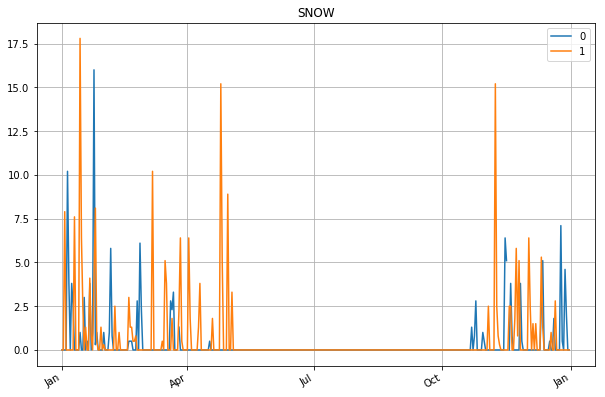

In [3]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()

YP.plot(T[:2,:].transpose(),fig,ax,title='SNOW')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [4]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/Users/Saransh/anaconda/envs/tensorflow_env/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


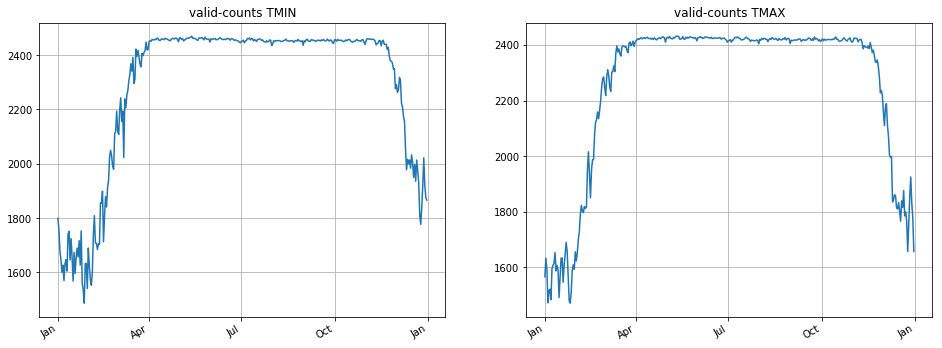

In [5]:
plot_pair(['TMIN','TMAX'],plot_valid)

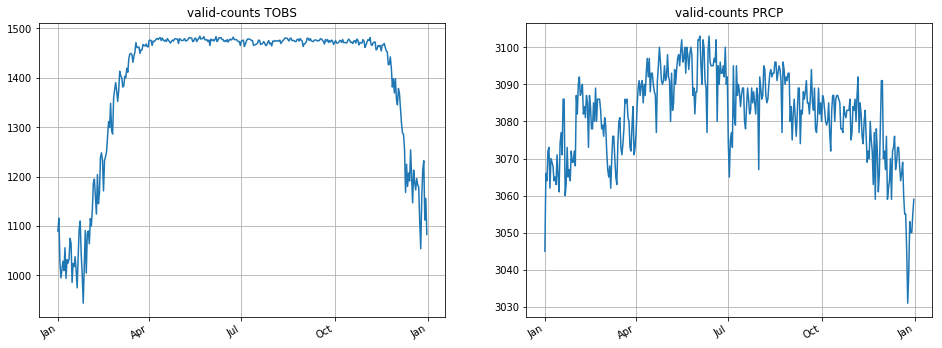

In [6]:
plot_pair(['TOBS','PRCP'],plot_valid)

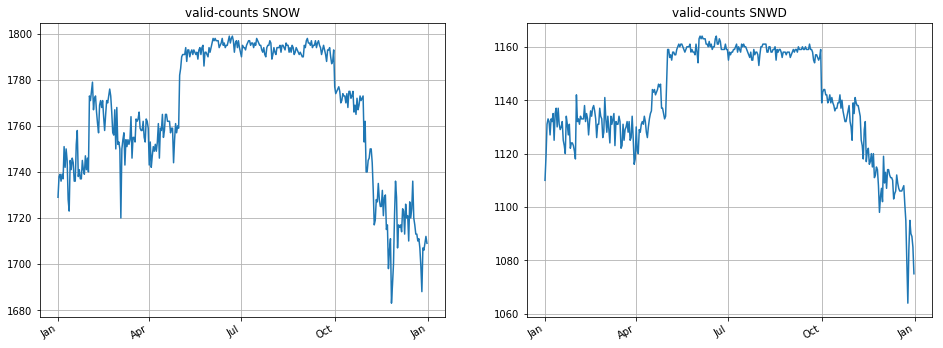

In [7]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [8]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

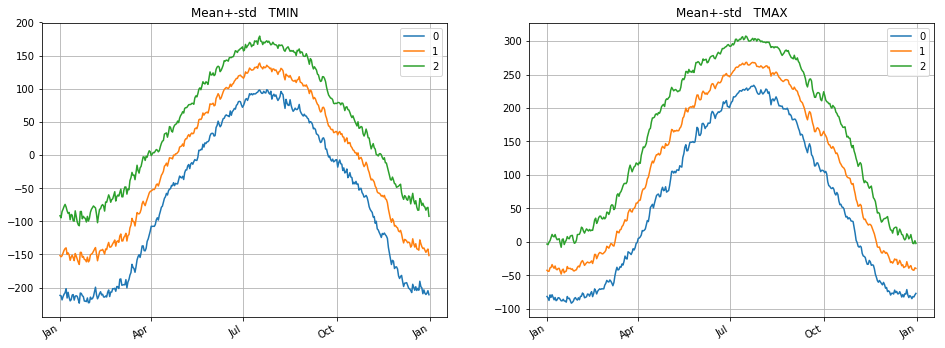

In [9]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

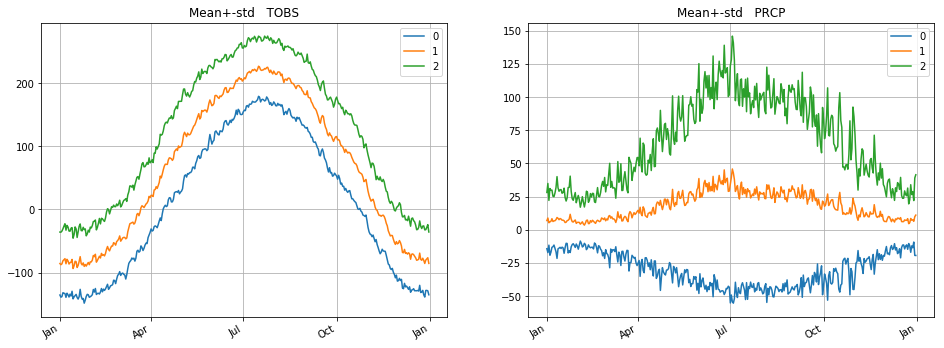

In [10]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

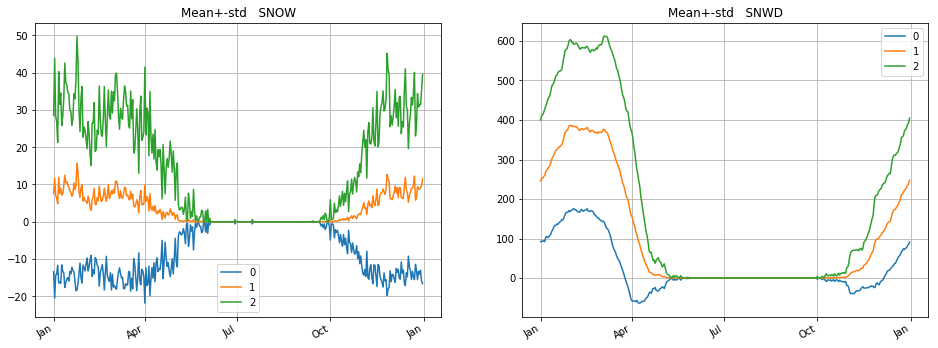

In [11]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [12]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

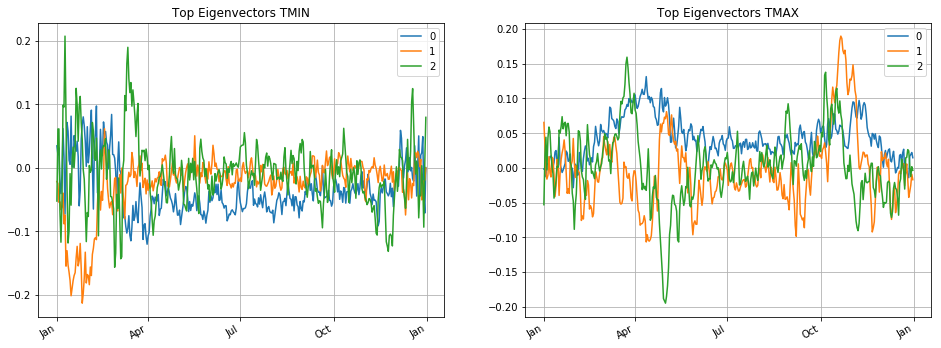

In [13]:
plot_pair(['TMIN','TMAX'],plot_eigen)

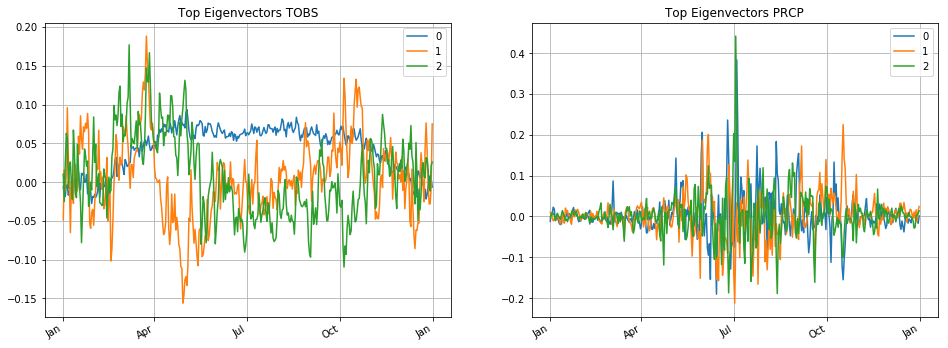

In [14]:
plot_pair(['TOBS','PRCP'],plot_eigen)

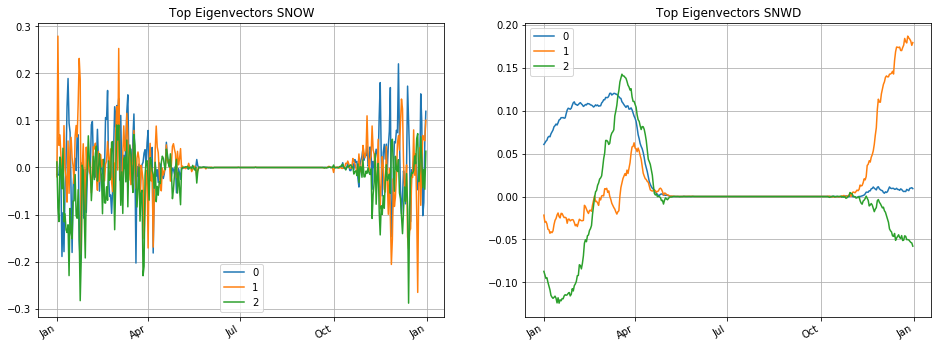

In [15]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [16]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

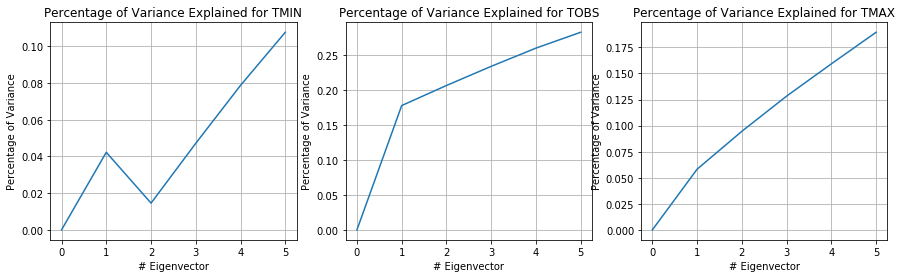

In [17]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

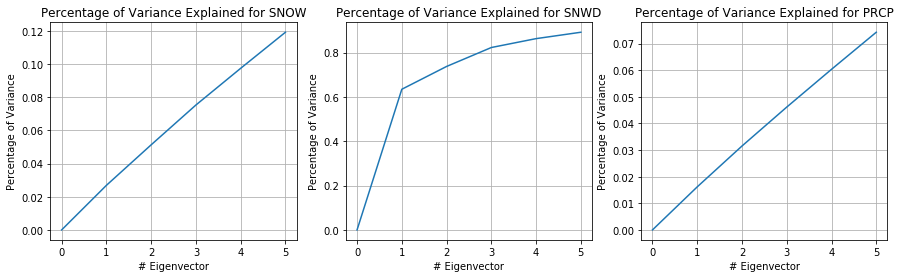

In [18]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [19]:
#sc.stop()

[(730857.0, 24.797715215764107, 24.281383000000002, 24.956057095265098, 24.109272261411967, 48808800.0), (730858.0, 24.329573318742369, 24.494800999999999, 24.763293056161185, 24.061081262581183, 35636600.0), (730859.0, 24.756407386319282, 24.343343000000001, 25.320930596032987, 24.116155453351286, 59083800.0), (730860.0, 24.391533110734017, 23.854548999999999, 24.419071516490792, 23.751281183187231, 51679400.0), (730861.0, 23.971583283113844, 23.785703000000002, 24.171232425092196, 23.58605385802165, 39583200.0), (730864.0, 23.613592124415842, 23.985351999999999, 24.226306340259701, 23.475902848142823, 58696400.0), (730865.0, 24.054196482260611, 23.875201999999998, 24.081734889273353, 23.469020651095736, 57115500.0), (730866.0, 23.37952173634265, 23.207411, 23.813241480369072, 23.186758400081825, 76428600.0), (730867.0, 23.441481389213656, 23.771934000000002, 23.923392135053351, 23.131681378158515, 50498800.0), (730868.0, 23.09725931603737, 23.049068999999999, 23.613591506897585, 22.8

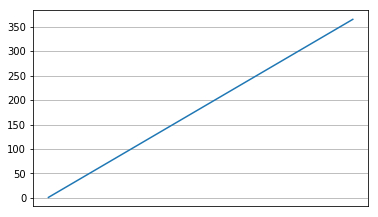

In [17]:
from __future__ import print_function
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import MONDAY
from matplotlib.finance import quotes_historical_yahoo_ochl
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter


date1 = datetime.date(2002, 1, 5)
date2 = datetime.date(2003, 12, 1)

# every monday
mondays = WeekdayLocator(MONDAY)

# every 3rd month
months = MonthLocator(range(1, 13), bymonthday=1, interval=3)
monthsFmt = DateFormatter("%m")


quotes = quotes_historical_yahoo_ochl('INTC', date1, date2)
if len(quotes) == 0:
    print('Found no quotes')
    raise SystemExit
    
dates = range(1,366)#[q[0] for q in quotes]
opens = range(1,366)#[q[1] for q in quotes]

print(quotes)

fig, ax = plt.subplots()
ax.plot_date(dates, opens, '-')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(mondays)
ax.autoscale_view()
#ax.xaxis.grid(False, 'major')
#ax.xaxis.grid(True, 'minor')
ax.grid(True)

fig.autofmt_xdate()

plt.show()